<a href="https://colab.research.google.com/github/Ykiiii/segment-anything/blob/main/yk_experiment_3Dseg_20231128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 挂载GD
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 挂载github
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/Ykiiii/segment-anything.git'


PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True
  Cloning https://github.com/Ykiiii/segment-anything.git to /tmp/pip-req-build-hloitoc2
  Running command git clone --filter=blob:none --quiet https://github.com/Ykiiii/segment-anything.git /tmp/pip-req-build-hloitoc2
  Resolved https://github.com/Ykiiii/segment-anything.git to commit 281842ac5c1d8b068a25321a2d6f18054d87c7db
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=31c9da4bb5f4164a3f8c578938e972189ca4b3d022424c77ce8f49c6f1311c52
  Stored in directory: /tmp/pip-ephem-wheel-cache-93rfhqai/wheels/88/98/e8/cae317a6e80121a62eb2e57868f75c783ac1ad689e303d2672
Successfully built segment-anything


In [ ]:
# 挂载数据
!mkdir datasets
!wget -P datasets http://ptak.felk.cvut.cz/darwin/t-less/v2/t-less_v2_test_primesense_20.zip
!mkdir datasets/t-less_v2_test_primesense_20
!unzip datasets/t-less_v2_test_primesense_20.zip -d datasets/t-less_v2_test_primesense_20


In [40]:
# 挂载SAM权重
!mkdir checkpoints
!wget -P checkpoints https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth  # 2.38G
# !wget -P checkpoints https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth  # 1.16G
# !wget -P checkpoints https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth  # 357M

mkdir: cannot create directory ‘checkpoints’: File exists
--2023-11-28 13:36:04--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.11, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘checkpoints/sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   228MB/s    in 13s     

2023-11-28 13:36:17 (190 MB/s) - ‘checkpoints/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



# Set-up

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2,os

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [57]:
rgbdir = 'datasets/t-less_v2_test_primesense_20/20/rgb/'
rgblist = os.listdir(rgbdir)
imglist = [element for element in rgblist if '.png' in element]
print(imglist)
print(len(imglist))
image = cv2.imread(rgbdir+imglist[50])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.axis('on')
plt.show()

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'datasets/t-less_v2_test_primesense_20/20/rgb/'

In [43]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95,
    crop_n_layers=0,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=0,  # Requires open-cv to run post-processing
)

参数
- model (Sam): The SAM model to use for mask prediction.
- points_per_side (int or None): The number of points to be sampled along one side of the image. The total number of points is points_per_side**2. If None, 'point_grids' must provide explicit point sampling.
- points_per_batch (int): Sets the number of points run simultaneously by the model. Higher numbers may be faster but use more GPU memory.
- pred_iou_thresh (float): A filtering threshold in [0,1], using the model's predicted mask quality.
- stability_score_thresh (float): A filtering threshold in [0,1], using the stability of the mask under changes to the cutoff used to binarize the model's mask predictions.
- stability_score_offset (float): The amount to shift the cutoff when calculated the stability score.
- box_nms_thresh (float): The box IoU cutoff used by non-maximal suppression to filter duplicate masks.
- crop_n_layers (int): If >0, mask prediction will be run again on crops of the image. Sets the number of layers to run, where each layer has 2**i_layer number of image crops.
- crop_nms_thresh (float): The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.
- crop_overlap_ratio (float): Sets the degree to which crops overlap. In the first crop layer, crops will overlap by this fraction of the image length. Later layers with more crops scale down this overlap.
- crop_n_points_downscale_factor (int): The number of points-per-side sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
- point_grids (list(np.ndarray) or None): A list over explicit grids of points used for sampling, normalized to [0,1]. The nth grid in the list is used in the nth crop layer. Exclusive with points_per_side.
- min_mask_region_area (int): If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area. Requires opencv.
- output_mode (str): The form masks are returned in. Can be 'binary_mask', 'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools. For large resolutions, 'binary_mask' may consume large amounts of memory.

In [44]:
masks = mask_generator.generate(image)

In [ ]:
print(masks)
print(len(masks))
print(masks[0].keys())

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

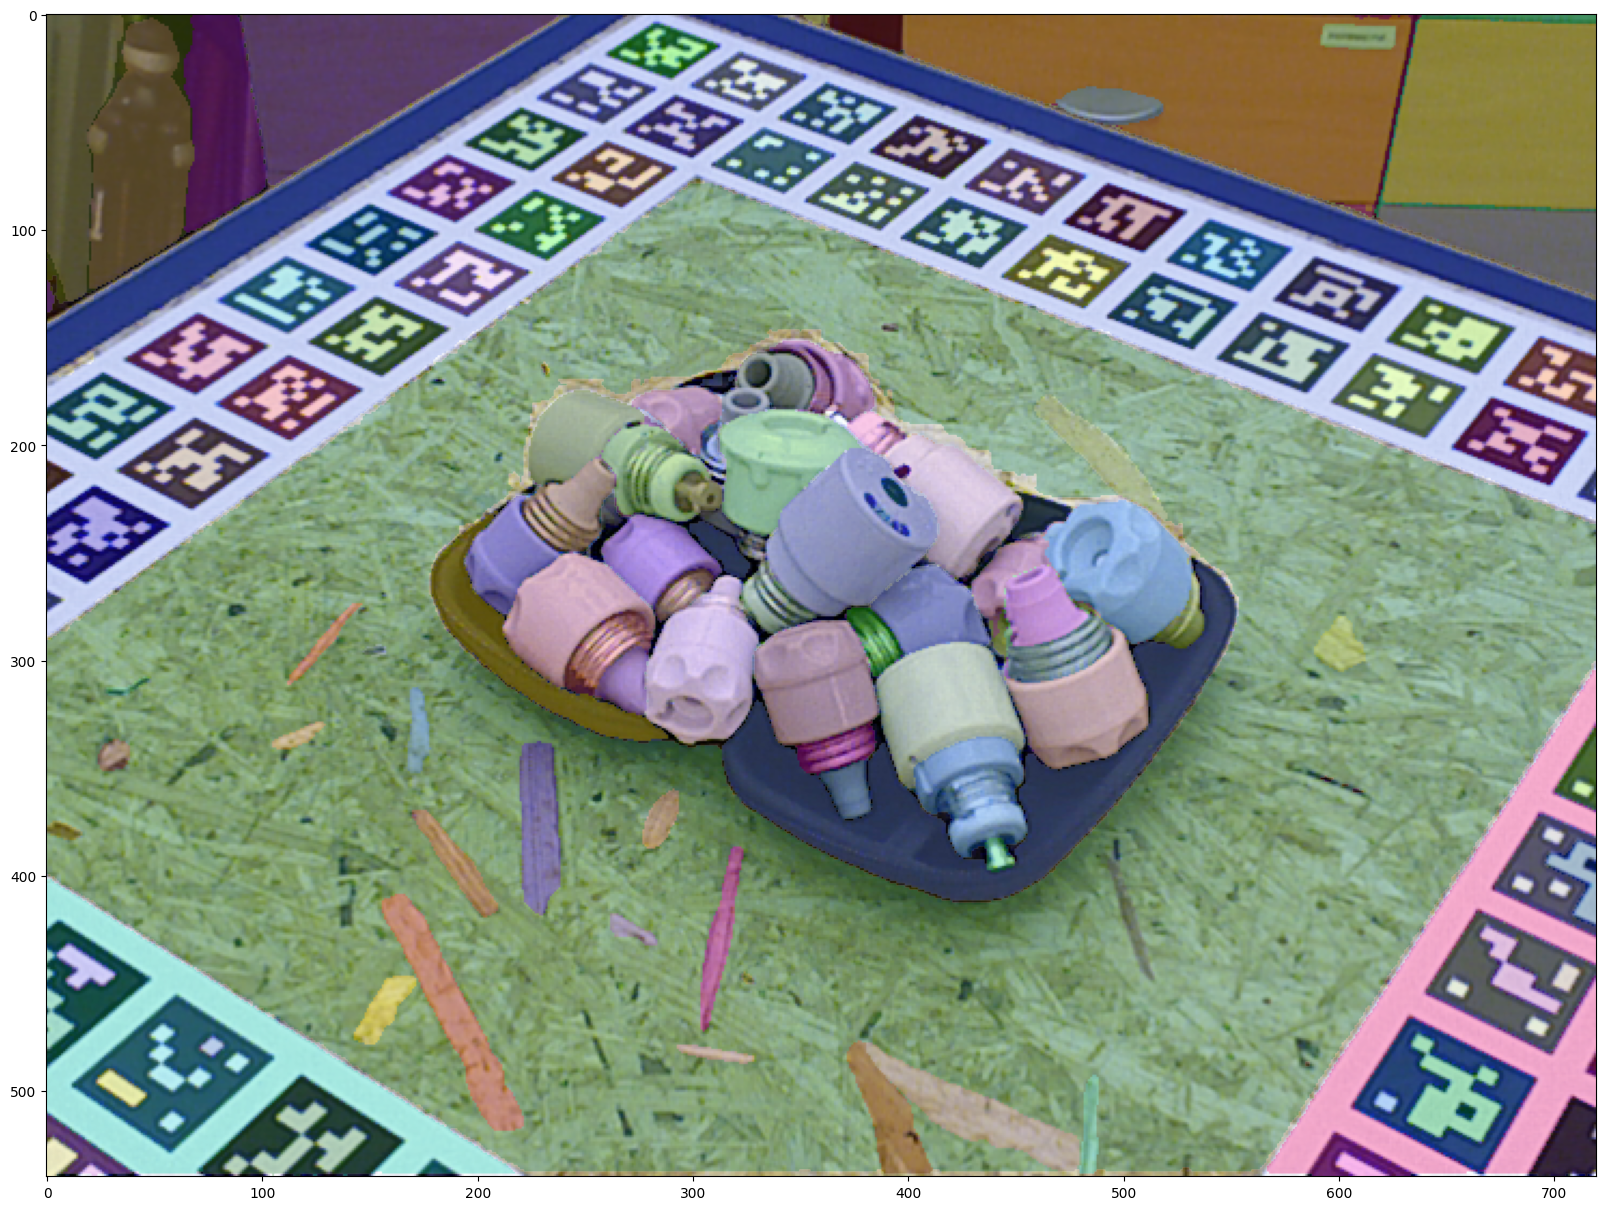

In [46]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('on')
plt.show()